In [1]:
%matplotlib inline

import sys
import numba
#import matlab.engine
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
from math import sqrt, log, floor, ceil
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.cluster import KMeans

# acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import load_fits, standarize

# extra metric module
import custom_metric as cm

/home/martin/miniconda2/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


## Loading 2D Data

In [2]:
"""
Loading data
"""

#fit_path = '../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits'
#fit_path = '../../bindata/fits/cubes/M100line.image.fits'
fit_path = '../../ACALIB/bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits'
#fit_path = '../../bindata/fits/cubes/ALMA01000740.fits'
container = load_fits(fit_path)
data = standarize(container.primary)[0]
data = data.data

#stacking it
data = data.sum(axis=0)
data /= data.max()

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: NDData was created with a masked array, and a mask was explicitly provided to NDData. The  explicitly passed-in mask will be used and the masked array's mask will be ignored. [astropy.nddata.nddata]


In [9]:
"""
Generating the data function
"""
x = np.linspace(0., 1., len(data[0]), endpoint=True)
y = np.linspace(0., 1., len(data[1]), endpoint=True)
f = sp.interpolate.interp2d(x, y, data, kind='linear')

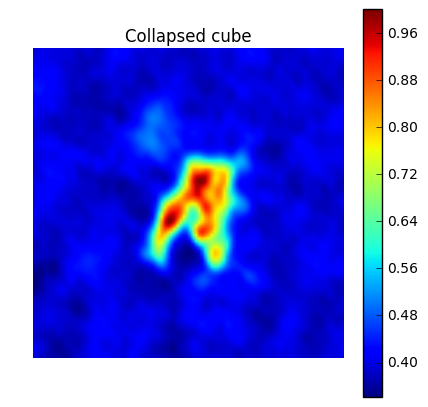

In [3]:
plt.figure(figsize=(5,5))
plt.imshow(data)
plt.title('Collapsed cube')
plt.axis('off')
plt.colorbar()
plt.show()

## Center points generation: Dynamic Approach

In [13]:
def R(x):
    ret = np.empty(x.shape)
    mask0 = x<2.
    mask1 = x>=2.
    ret[mask0] = np.cos(np.pi/2 * x[mask0])
    ret[mask1] = -2 / (1. + np.exp((x[mask1]-2)**2))
    return ret

def d(x, sigmin=0.05, sigmax=0.25):
    alpha = -np.log(sigmin/sigmax)
    return sigmax * np.exp(-alpha * x)
    

class APoints():
    def __init__(self, n_points, dfunc, eps=1e-10):
        self.n_points = n_points
        self.dfunc = dfunc
        self.eps = 1e-10
  
    def F(self, points, t=0.):
        points = points.reshape((self.n_points,2))
        # distance matrices
        Dx = np.empty((self.n_points, self.n_points))
        Dy = np.empty((self.n_points, self.n_points))
        for i in range(points.shape[0]):
            Dx[i] = points[:,0] - points[i,0] 
            Dy[i] = points[:,1] - points[i,1]
        D = np.sqrt(Dx**2 + Dy**2) + self.eps
        # intensities at each point
        I = np.diagonal(self.dfunc(points[:,0], points[:,1]))
        # computing derivatives
        tmp = R(D / d(I))
        tmp /= D
        dX = (Dx * tmp).sum(axis=1)
        dY = (Dy * tmp).sum(axis=1)
        ret = np.vstack([dX,dY]).T
        return ret.ravel()

$$
R(x) = \begin{cases} 
      \cos(\frac{\pi}{2} x) &  0 \leq x < 2 \\
      \frac{-2}{1 + e^{(x-2)^2}} & 2 \leq x
\end{cases}
$$

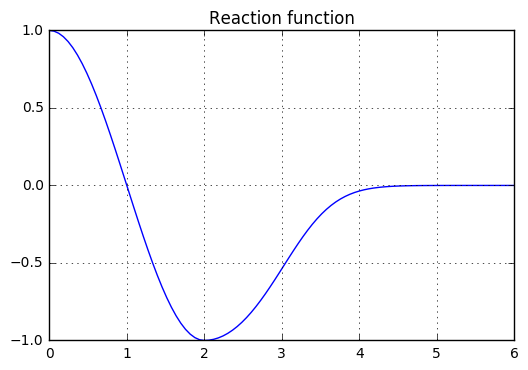

In [14]:
xgrid = np.linspace(0., 6., 100)
plt.plot(xgrid, R(xgrid))
plt.title('Reaction function')
plt.grid()
plt.show()

**Note**: Remember that the intensity values are bounded in the $[0,1]$ interval.

$$
d(I) = \sigma_{\text{max}} e^{-\alpha x} \ \ \ \ \ \text{with} \ \ \ \ \alpha = - \ln \left(\frac{\sigma_{\text{min}}}{\sigma_{\text{max}}}\right)
$$

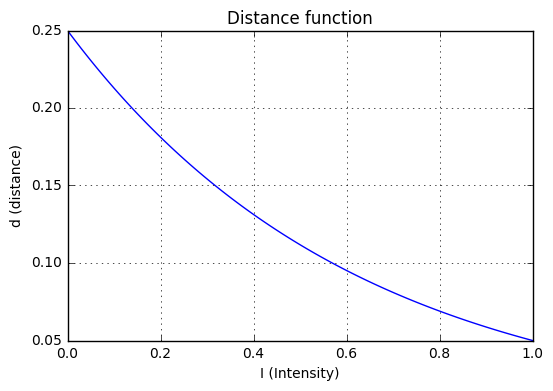

In [6]:
xgrid = np.linspace(0., 1., 100)
plt.plot(xgrid, d(xgrid))
plt.title('Distance function')
plt.xlabel('I (Intensity)')
plt.ylabel('d (distance)')
plt.grid()
plt.show()

### Testing: Uniform Grid as initial state

In [7]:
_xe = np.linspace(0., 1., 10)[1:-1]
_ye = np.linspace(0., 1., 10)[1:-1]
Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
xe = Xe.ravel(); ye = Ye.ravel()
center_points = np.hstack((xe.reshape(-1,1), ye.reshape(-1,1)))

In [10]:
ap = APoints(center_points.shape[0], f)

In [11]:
%timeit ap.F(center_points.flatten())

1000 loops, best of 3: 482 µs per loop


In [12]:
time_grid = np.linspace(0., 2., 100)
sol = sp.integrate.odeint(ap.F, center_points.flatten(), time_grid)

/home/martin/miniconda2/lib/python2.7/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [16]:
sol[-1].reshape(center_points.shape)

array([[ -8.27033883e-01,  -7.38796059e-01],
       [ -2.39925206e-07,  -3.25287088e-05],
       [ -1.35995043e-03,  -1.90784228e-02],
       [ -9.99525497e-02,  -2.31431214e-01],
       [ -2.95501074e-01,  -2.31431214e-01],
       [ -6.05386448e-09,  -9.16091775e-07],
       [ -4.52039051e-05,  -7.88282874e-04],
       [ -5.36477763e-03,  -1.58808401e-02],
       [ -2.24954104e-02,  -1.58808401e-02],
       [ -1.68643640e-07,  -5.39058451e-05],
       [ -4.58711091e-03,  -1.02668546e-01],
       [ -5.46253358e-01,  -9.40543807e-01],
       [ -8.57136242e-07,  -2.26218531e-04],
       [ -1.54519381e-02,  -2.47551637e-01],
       [ -8.17890380e-01,  -7.74297386e-09],
       [ -1.05056283e-05,  -2.67326656e-03],
       [ -1.20377400e-01,  -7.30553656e-01],
       [ -7.70099169e-09,  -9.11463785e-06],
       [ -2.12677041e-03,  -9.46152405e-02],
       [ -6.43975289e-01,  -9.99702346e-01],
       [ -1.47587449e-45,  -1.69256066e-32],
       [ -7.90970819e-22,  -1.61276341e-13],
       [ -